In [3]:
import pandas as pd
import paramiko
import os
import numpy as np
import math

## Remote connection parameters

In [4]:
hostname = "169.229.154.119"
username = "cy290e"
password = ""  # local password 
#local_key_dir = '~/.ssh/known_hosts'
local_key_dir = 'C:/Users/Ruoying/.ssh'
"""SSH connection parameters"""

listings_dir = 'craigslist_census_02202017/'
"""Remote directory for results"""

# estbalish SSH connection
ssh = paramiko.SSHClient() 
ssh.load_host_keys(local_key_dir)
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect(hostname,username=username, password=password)
sftp = ssh.open_sftp()

IOError: [Errno 13] Permission denied: 'C:/Users/Ruoying/.ssh'

In [1]:
#https://www.example-code.com/python/sftp_use_ppk_putty_private_key.asp
import sys
import chilkat

In [2]:
sftp = chilkat.CkSFtp()
success = sftp.UnlockComponent("Anything for 30-day trial.")
if (success != True):
    print(sftp.lastErrorText())
    sys.exit()

In [3]:
#  Load a .ppk PuTTY private key.
puttyKey = chilkat.CkSshKey()
ppkText = puttyKey.loadText("C:/Users/Ruoying/.ssh/putty_rsa_private.ppk")

In [4]:
puttyKey.put_Password("")
success = puttyKey.FromPuttyPrivateKey(ppkText)
if (success != True):
    print(puttyKey.lastErrorText())
    sys.exit()

In [5]:
sshHostname = "169.229.154.119"
sshPort = 22
success = sftp.Connect(sshHostname,sshPort)
if (success != True):
    print(sftp.lastErrorText())
    sys.exit()

In [6]:
success = sftp.AuthenticatePk("cy290e",puttyKey)
if (success != True):
    print(sftp.lastErrorText())
    sys.exit()

In [7]:
def read_listings_file(fname):
    """Read csv file via SFTP and return as dataframe."""
    with sftp.open(listings_dir+fname) as f:
        df = pd.read_csv(f, delimiter=',', dtype={'date':str,'fips_block':str,'state':str,'mpo_id':str})
        # TODO: parse dates. 
    return df

def filter_outliers(df, rent_range=(100,10000),sqft_range=(10,5000)):
    """Drop outliers from listings dataframe. For now, only need to filter out rent and sq ft. 
    Args: 
        df: Dataframe with listings. Cols names include ['rent','sqft']
        rent_range (tuple): min and max rent
        sqft_range (tuple): min and max sqft
    Returns: 
        DataFrame: listings data without outliers. 
    """
    n0=len(df)
    df=df[(df.rent>=rent_range[0])&(df.rent<rent_range[1])]
    n1=len(df)
    print('Dropped {} outside rent range ${}-${}'.format(n0-n1,rent_range[0],rent_range[1]))
    df=df[(df.sqft>=sqft_range[0])&(df.sqft<sqft_range[1])]
    n2=len(df)
    print('Dropped {} outside sqft range {}-{} sqft. {} rows remaining'.format(n1-n2,sqft_range[0],sqft_range[1],len(df)))
    return(df)

## Load data

In [8]:
# get list of files and load. 
# TODO: decide what to load. 
state='NY'
infile='cl_census_{}.csv'.format(state)
df = read_listings_file(infile)
df.head()

AttributeError: type object 'object' has no attribute '__getattr__'

In [92]:
# for census vars, NA really means 0...
census_cols = ['cars_tot', 'children_tot','persons_tot', 'workers_tot', 'age_of_head_med', 'income_med','hhs_tot', 'race_of_head_1', 'race_of_head_2', 'race_of_head_3','race_of_head_4', 'race_of_head_5', 'race_of_head_6', 'race_of_head_7','race_of_head_8', 'race_of_head_9', 'recent_mover_0', 'recent_mover_1','tenure_1', 'tenure_2']
for col in census_cols:
    df[col] = df[col].fillna(0)

In [93]:
df[census_cols].head()

,cars_tot,children_tot,persons_tot,workers_tot,age_of_head_med,income_med,hhs_tot,race_of_head_1,race_of_head_2,race_of_head_3,race_of_head_4,race_of_head_5,race_of_head_6,race_of_head_7,race_of_head_8,race_of_head_9,recent_mover_0,recent_mover_1,tenure_1,tenure_2
0,621,119,718,345,56,57000,306,306,0,0,0,0,0,0,0,0,306,0,278,28
1,695,155,877,517,58,67500,356,334,22,0,0,0,0,0,0,0,350,6,348,8
2,872,264,1128,606,51,103000,477,425,0,3,0,1,40,0,1,7,425,52,264,213
3,2032,328,2464,1441,52,51000,1203,1128,0,0,0,0,75,0,0,0,861,342,614,589
4,1389,106,1671,809,64,71620,1023,997,22,0,0,0,4,0,0,0,847,176,650,373


In [94]:
# make meaningful variables.
df['pct_race_1'] = df['race_of_head_1']/df['hhs_tot']
df['pct_race_2'] = df['race_of_head_2']/df['hhs_tot']
df['pct_race_3'] = df['race_of_head_3']/df['hhs_tot']
df['pct_mover'] = df['recent_mover_1']/df['hhs_tot']
df['pct_tenure_1'] = df['tenure_1']/df['hhs_tot']
df['avg_hh_size'] = df['persons_tot']/df['hhs_tot']
df['cars_per_hh'] = df['cars_tot']/df['hhs_tot']


df['ln_rent'] = np.log(df['rent'])

In [95]:
features_to_examine = ['rent','ln_rent', 'bedrooms', 'sqft','pct_race_1','pct_race_2','pct_race_3','pct_mover','pct_tenure_1','income_med','age_of_head_med','avg_hh_size','cars_per_hh']
df[features_to_examine].describe()

,rent,ln_rent,bedrooms,sqft,pct_race_1,pct_race_2,pct_race_3,pct_mover,pct_tenure_1,income_med,age_of_head_med,avg_hh_size,cars_per_hh
count,54934.000000,54934.000000,54934.000000,54934.000000,54399.000000,54399.000000,54399.000000,54399.000000,54399.000000,54934.000000,54934.000000,54399.000000,54399.000000
mean,4397.204973,7.256942,2.031693,1125.127808,0.785019,0.112677,0.001894,0.204687,0.458737,59514.072806,48.418520,2.211441,1.208953
std,178219.456117,0.686124,1.124379,4769.754000,0.255684,0.213344,0.004698,0.145567,0.297378,33497.944359,9.401062,0.502620,0.650050
min,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,885.000000,6.785588,1.000000,778.000000,0.710448,0.000000,0.000000,0.098214,0.199211,36800.000000,45.000000,1.868852,0.577375
50%,1345.000000,7.204149,2.000000,1000.000000,0.880579,0.020938,0.000000,0.181271,0.464939,52200.000000,50.000000,2.182510,1.369110
75%,2200.000000,7.696213,3.000000,1240.000000,0.973856,0.099259,0.002454,0.284289,0.681514,75000.000000,54.000000,2.535857,1.751625
max,23772584.000000,16.984044,9.000000,850825.000000,1.000000,1.000000,0.390339,0.920128,1.000000,269600.000000,76.000000,5.700608,2.692771


## Filter outliers

Can use the following to examine outliers...

In [96]:
rent_range=(100,10000)
sqft_range=(10,5000)
"""Ranges to define outliers in CL data. I defined based on inspection of distributions."""

'Ranges to define outliers in CL data. I defined based on inspection of distributions.'

//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


(0, 10000)

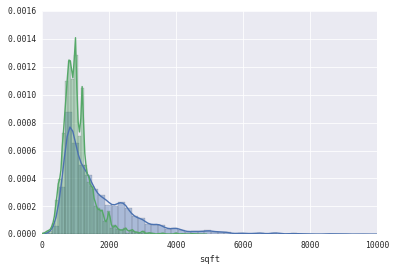

In [119]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# use this to define outliers. 
g=sns.distplot(df['rent'])
g.set_xlim(0,100000)

g=sns.distplot(df['sqft'])
g.set_xlim(0,10000)

In [97]:
df = filter_outliers(df)

Dropped 314 outside rent range $100-$10000
Dropped 181 outside sqft range 10-5000 sqft. 54439 rows remaining


## drop NA

In [107]:
df = df[features_to_examine]
print(len(df))
print(len(df[pd.isnull(df).any(axis=1)]))
df = df.dropna()

54439
532


## look at distributions

Since rent has a more or less logarithmic distribution, we use ln_rent instead

//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


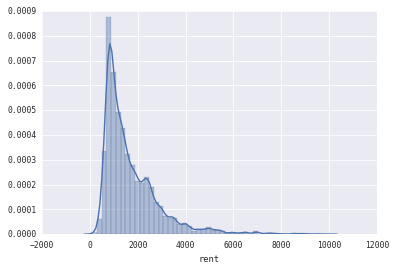

In [109]:
sns.distplot(df.rent)

//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


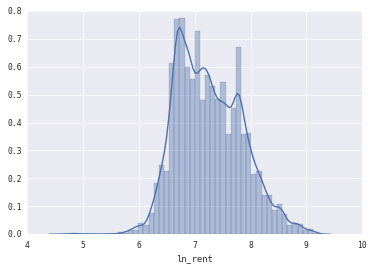

In [110]:
sns.distplot(df.ln_rent)

//anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


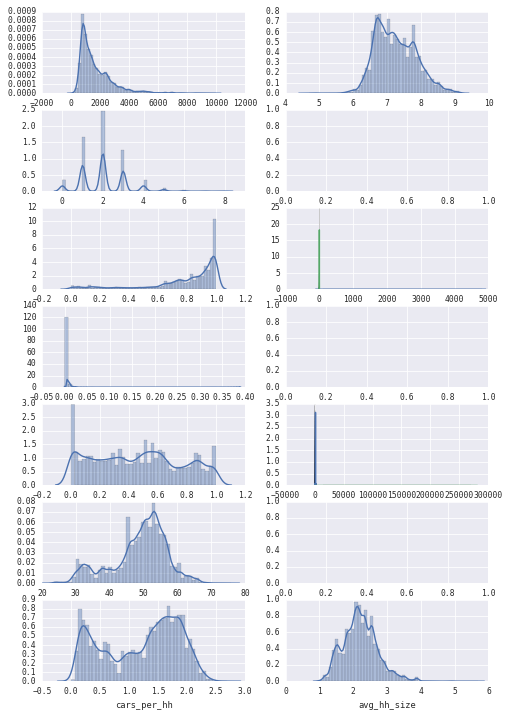

In [121]:
plot_rows = math.ceil(len(features_to_examine)/2)

f, axes = plt.subplots(plot_rows,2, figsize=(8,12))
sns.despine(left=True)

for i,col in enumerate(features_to_examine):
    row_position = round(i/2)
    col_position = i%2
    p=sns.distplot(df[col], ax=axes[row_position, col_position])
    p.set_title(''.format(col))  # while isn't the subplot title working? 
plt.show()


## look at correlations

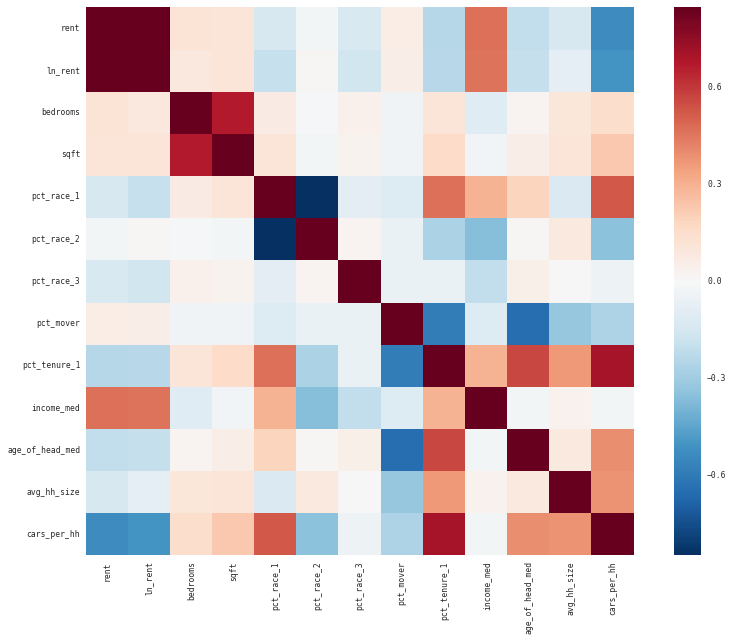

In [45]:
# correlation heatmap
corrmat=df[features_to_examine].corr()
corrmat.head()

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

f.tight_layout()